# 2-1. 프로젝트 : 폐렴 진단기 성능개선

조금 전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀 더 분발해야겠죠?

그렇다면 우리는 조금 전까지의 실습 과정을 되짚어보면서, 어떤 점을 더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 더 성능을 향상시켜 보려고 합니다.

우선 주요 라이브러리 버전을 확인해 봅시다.

# Step 1. 실험환경 Set-up

거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [162]:
import os, re
import random, math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [163]:
import seaborn as sns
import cv2
import os
from PIL import Image
from glob import glob
import tensorflow as tf

## Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.  
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.  
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [212]:
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 128
EPOCHS = 10

In [173]:
main_path = "./data/"

train_normal = glob(os.path.join(main_path, "train", "NORMAL", "*.jpeg"))
train_pneumonia = glob(os.path.join(main_path, "train", "PNEUMONIA", "*.jpeg"))

test_normal = glob(os.path.join(main_path, "test", "NORMAL", "*.jpeg"))
test_pneumonia = glob(os.path.join(main_path, "test", "PNEUMONIA", "*.jpeg"))

val_normal = glob(os.path.join(main_path, "val", "NORMAL", "*.jpeg"))
val_pneumonia = glob(os.path.join(main_path, "val", "PNEUMONIA", "*.jpeg"))

In [174]:
df_train = pd.DataFrame({
    'class': ['Normal'] * len(train_normal) + ['Pneumonia'] * len(train_pneumonia),
    'image': train_normal + train_pneumonia})

df_test = pd.DataFrame({
    'class': ['Normal'] * len(test_normal) + ['Pneumonia'] * len(test_pneumonia),
    'image': test_normal + test_pneumonia})

df_val = pd.DataFrame({
    'class': ['Normal'] * len(val_normal) + ['Pneumonia'] * len(val_pneumonia),
    'image': val_normal + val_pneumonia})

In [175]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5216 non-null   object
 1   image   5216 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB


In [178]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   16 non-null     object
 1   image   16 non-null     object
dtypes: object(2)
memory usage: 384.0+ bytes


In [176]:
# train, val 데이터 합침
df_train = pd.concat([df_train, df_val], axis=0)

# 인덱스 초기화
df_train = df_train.reset_index(drop=True)

In [177]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5232 non-null   object
 1   image   5232 non-null   object
dtypes: object(2)
memory usage: 81.9+ KB


In [191]:
df_train.sample(10)

,class,image
3426,Pneumonia,./data/train/PNEUMONIA/person957_bacteria_2882...
571,Normal,./data/train/NORMAL/IM-0487-0001.jpeg
853,Normal,./data/train/NORMAL/NORMAL2-IM-0793-0001.jpeg
2339,Pneumonia,./data/train/PNEUMONIA/person327_bacteria_1509...
5167,Pneumonia,./data/train/PNEUMONIA/person286_virus_585.jpeg
4080,Pneumonia,./data/train/PNEUMONIA/person940_virus_1607.jpeg
717,Normal,./data/train/NORMAL/NORMAL2-IM-1271-0001.jpeg
875,Normal,./data/train/NORMAL/NORMAL2-IM-0906-0001.jpeg
1322,Normal,./data/train/NORMAL/NORMAL2-IM-0772-0001.jpeg
1177,Normal,./data/train/NORMAL/IM-0549-0001.jpeg


In [194]:
TRAIN_IMG_COUNT = df_train.shape[0]
COUNT_PNEUMONIA = df_train[df_train['class'] == 'Pneumonia'].shape[0]
COUNT_NORMAL = df_train[df_train['class'] == 'Normal'].shape[0]

In [196]:
TRAIN_IMG_COUNT, COUNT_PNEUMONIA, COUNT_NORMAL

(4185, 3883, 1349)

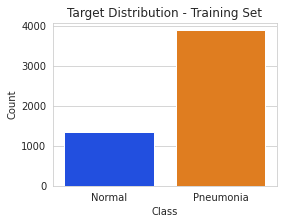

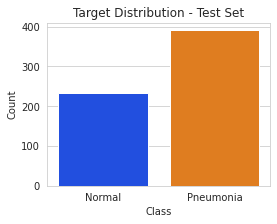

In [179]:
# 정상/폐렴 분포도 확인

plt.figure(figsize=(4, 3))
sns.countplot(data=df_train, x='class')
plt.title('Target Distribution - Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(4, 3))
sns.countplot(data=df_test, x='class')
plt.title('Target Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

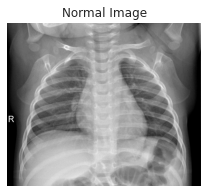

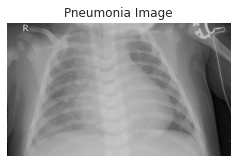

In [180]:
image_path1 = df_train['image'][1]
try:
    image1 = Image.open(image_path1)
    plt.figure(figsize=(4,3))
    plt.imshow(image1, cmap='gray')
    plt.title('Normal Image')
    plt.axis('off')
    plt.show()
except (IOError, OSError) as e:
    print(f"Error opening image: {e}")

image_path2 = df_train['image'][5110]
try:
    image2 = Image.open(image_path2)
    plt.figure(figsize=(4,3))
    plt.imshow(image2, cmap='gray')
    plt.title('Pneumonia Image')
    plt.axis('off')
    plt.show()
except (IOError, OSError) as e:
    print(f"Error opening image: {e}")

In [165]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 42, stratify = df_train['class'])

In [166]:
train_df.shape, val_df.shape

((4185, 2), (1047, 2))

## Augmentation - ImageDataGenerator 사용

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [225]:
img_width = IMAGE_SIZE[0]
img_height = IMAGE_SIZE[1]
batch_size = BATCH_SIZE

In [226]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 제너레이터
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 테스트 데이터셋은 스케일만 조정
val_datagen = ImageDataGenerator(rescale=1./255)

# 데이터별 제너레이터 생성
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(img_width, img_height),
    batch_size=batch_size
)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(img_width, img_height),
    batch_size=batch_size
)

ds_test = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(img_width, img_height),
    batch_size=1
)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [227]:
ds_train.n, ds_val.n, ds_test.n

(4185, 1047, 624)

# Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.  
만약 augmentation을 시도했다면 이후 실습 코드에 있는 `show_batch()` 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

In [104]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch, batch_size=batch_size):
    plt.figure(figsize=(10,10))
    for n in range(batch_size):
        ax = plt.subplot(4,math.ceil(batch_size/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


In [185]:
image_batch, label_batch = next(iter(ds_train))

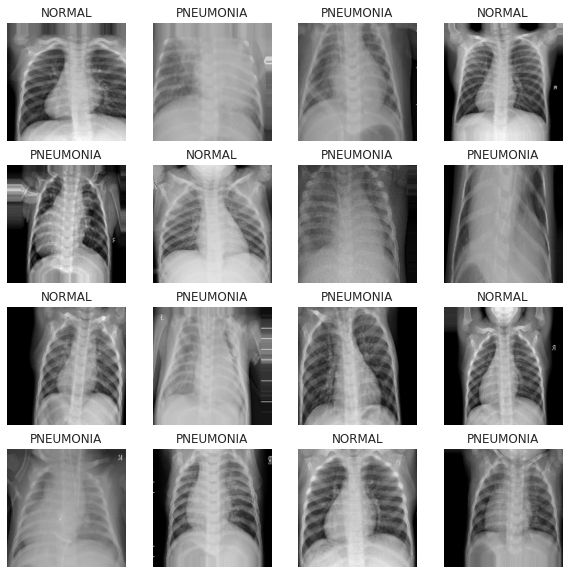

In [187]:
show_batch(image_batch, label_batch, batch_size=16)

# Step 4. ResNet-18 구현

의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다. ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.

ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.

우리는 ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

1. 3x3 CNN
2. BatchNormalization

로 구성되어 있습니다.

위에 있는 그림대로 Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)

In [26]:
import math
from tensorflow import keras
from tensorflow.keras import layers

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

In [27]:
def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

In [28]:
def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

In [30]:
def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

In [63]:
def resnet(input_shape, blocks_per_layer, num_classes=1000):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(inputs)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, 
                      kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    
    # initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    # outputs = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)
    outputs = layers.Dense(1, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='resnet18')
    return model

def resnet18(input_shape, **kwargs):
    return resnet(input_shape, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

# Step 5. 데이터 imbalance 처리

실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 `class_weight`를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [228]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.55
Weight for PNEUMONIA: 0.54


# Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [202]:
with tf.device('/GPU:0'):
    # model = build_model()
    # model = resnet18(train_ds)
    model = resnet18((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model.summary()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 87, 87, 64)   9408        input_17[0][0]                   
__________________________________________________________________________________________________
maxpool (MaxPooling2D)          (None, 43, 43, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
layer1.0.conv1_pad (ZeroPadding (None, 45, 45, 64)   0           maxpool[0][0]                    
___________________________________________________________________________________________

In [203]:
with tf.device('/GPU:0'):
    history = model.fit(
        ds_train,
        steps_per_epoch=ds_train.n // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=ds_val,
        validation_steps=ds_val.n // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 86s 640ms/step - loss: 0.2846 - accuracy: 0.7424 - precision: 0.7424 - recall: 1.0000 - val_loss: 0.3215 - val_accuracy: 0.7441 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 82s 631ms/step - loss: 0.2106 - accuracy: 0.7428 - precision: 0.7428 - recall: 1.0000 - val_loss: 0.2093 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 81s 625ms/step - loss: 0.1735 - accuracy: 0.7421 - precision: 0.7421 - recall: 1.0000 - val_loss: 0.3920 - val_accuracy: 0.7441 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 81s 622ms/step - loss: 0.1776 - accuracy: 0.7426 - precision: 0.7426 - recall: 1.0000 - val_loss: 0.4413 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 81s 624ms/step - loss: 0.1487 - accura

### 단순 모델

In [206]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    inputs = Input(shape=(180, 180, 3))
    
    x = Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    
    x = Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    
    x = Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    
    x = Conv2D(128, (3, 3), strides=1, padding='valid', activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    
    x = Conv2D(256, (3, 3), strides=1, padding='valid', activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)
    
    x = Flatten()(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(units=1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model


In [229]:
model = create_model()

In [233]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=METRICS
)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 178, 178, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
dropout_10 (Dropout)         (None, 87, 87, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 87, 87, 64)        256 

In [231]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-7,restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss',factor = 0.2,patience = 2,min_delt = 1e-7,cooldown = 0,verbose = 1) 

In [234]:
with tf.device('/GPU:0'):
    history = model.fit(ds_train,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        validation_data=ds_val,
                        callbacks=[early_stopping, plateau],
                        steps_per_epoch=(len(train_df)/BATCH_SIZE),
                        validation_steps=(len(val_df)/BATCH_SIZE));

Epoch 1/10
32/32 [==============================] - 89s 3s/step - loss: 0.2385 - accuracy: 0.9035 - precision: 0.9380 - recall: 0.9309 - val_loss: 0.6884 - val_accuracy: 0.7421 - val_precision: 0.7421 - val_recall: 1.0000
Epoch 2/10
32/32 [==============================] - 86s 3s/step - loss: 0.2194 - accuracy: 0.9102 - precision: 0.9426 - recall: 0.9359 - val_loss: 0.8284 - val_accuracy: 0.7421 - val_precision: 0.7421 - val_recall: 1.0000
Epoch 3/10
32/32 [==============================] - 87s 3s/step - loss: 0.2134 - accuracy: 0.9082 - precision: 0.9359 - recall: 0.9408 - val_loss: 1.0266 - val_accuracy: 0.7421 - val_precision: 0.7421 - val_recall: 1.0000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
Epoch 4/10
32/32 [==============================] - 88s 3s/step - loss: 0.2069 - accuracy: 0.9125 - precision: 0.9457 - recall: 0.9359 - val_loss: 1.1675 - val_accuracy: 0.7421 - val_precision: 0.7421 - val_recall: 1.0000
Epoch 5/10
32/32 [============

# Step 7. 결과 확인과 시각화

테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

In [171]:
def get_result(test_dataset=test_dataset):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    loss, accuracy, precision, recall = model.evaluate(test_dataset)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

## Try 1:

> Resnet 모델로 구성해도 큰 차이는 없는 것 같다.

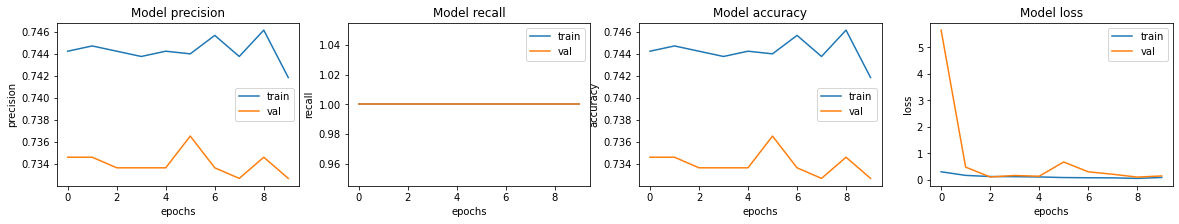

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [54]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 114ms/step - loss: 0.7203 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.7203027009963989,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## Try 2:

> 모델 입력쪽에 conv, maxpooling 을 제외한 zero padding 등을 없앰

39/39 [==============================] - 5s 119ms/step - loss: 1.0252 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.0251796245574951,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


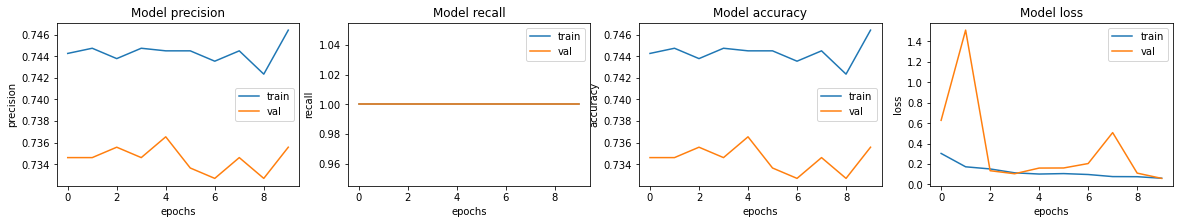

In [67]:
get_result()

> 크게 차이가 없음

## Try 3:

> ImageDataGeneration 사용

39/39 [==============================] - 5s 122ms/step - loss: 0.5156 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.5155861973762512,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


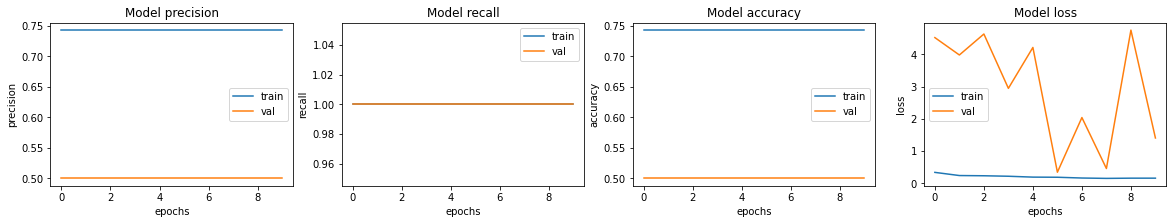

In [81]:
get_result()

> validation dataset 수가 적어서 이런 결과가 나온 것 같다.  
> 데이터를 나누지 않아서, 16개.  

## Try 4:

> ImageDataGenerator 안쓰고, 원래 데이터셋으로 씀.  
> optimizer: 'rmsprop'

39/39 [==============================] - 5s 129ms/step - loss: 5.8507 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 5.850707054138184,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


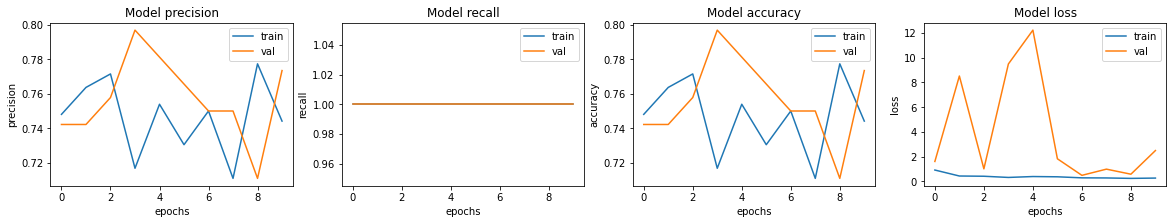

In [111]:
get_result()

> 정확도는 차이가 없고, loss 값이 올라갔다.

## Try 5:

> optimizer = adam 으로 재설정  
> ImagaDataGenerator 로 데이터셋 다시 만듬  
> 그리고... 이제까지 테스트 데이터셋에 문제가 있음을 발견..

624/624 [==============================] - 8s 13ms/step - loss: 0.2653 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.2652757465839386,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


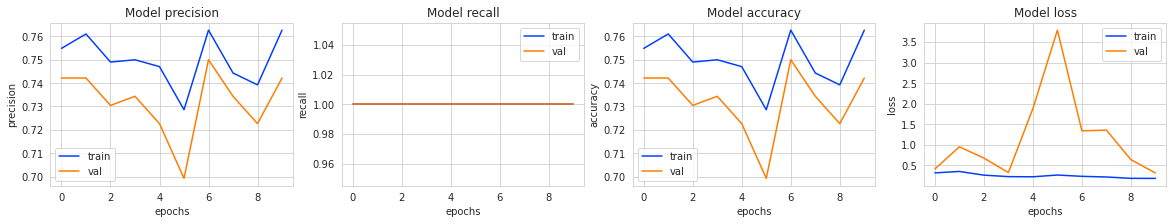

In [172]:
get_result(ds_test)

> 아니.... 뭘 해도 정확도 값이 이렇게 변하지 않을 수가 있나?????  
> 0.625에 발목 잡혔네...

## Try 6:

> 의미없겠으나 혹시나, 혹시나해서 batch_size를 128 --> 32로 조정해봄.  
> 역시나... 역시나...  

624/624 [==============================] - 8s 12ms/step - loss: 0.6864 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6863654255867004,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


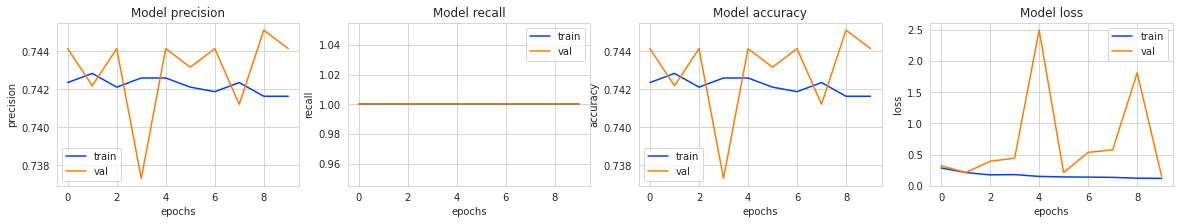

In [205]:
get_result(ds_test)

## Try 7:

> resnet에 문제가 있나해서, 간단한 모델로 바꿔봄 

624/624 [==============================] - 7s 11ms/step - loss: 0.9642 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.964155912399292,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


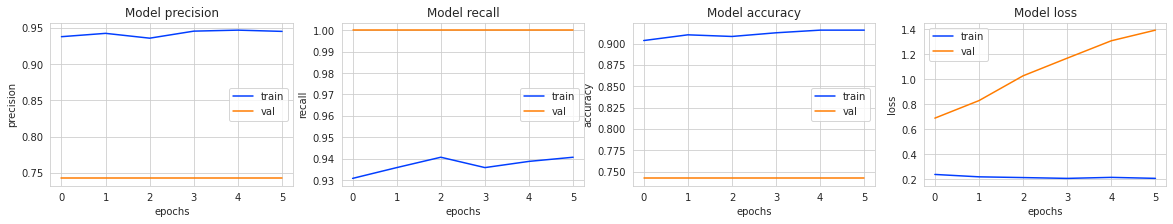

In [235]:
get_result(ds_test)

> 학습 정확도는 0.9 이상 나오는데, 테스트 정확도는 왜 똑같이 0.625지?  
> 오버핏인가...? 그런데 왜 0.625밖에 나오지 않지???? 